In [127]:
# !python parallelosaurus.py

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib as mpl
import glob

In [143]:
df = pd.read_csv("minisaurus_parallel.csv").fillna(0).drop(columns=['model_number', 'gyre_fn', 'num_zones', 
                                                                    'priority','star_age', 'num_retries','num_iters'])
df.columns

Index(['log_dt', 'star_mass', 'log_LH', 'log_LHe', 'log_LZ', 'log_Lnuc', 'pp',
       'cno', 'tri_alpha', 'he_core_mass', 'log_Teff', 'logL', 'log_R',
       'log_g', 'surf_avg_omega_div_omega_crit', 'surf_avg_v_rot',
       'log_cntr_P', 'log_cntr_Rho', 'log_cntr_T', 'center_h1', 'center_he4',
       'average_h1', 'average_he4', 'total_mass_h1', 'total_mass_he4',
       'dnu_muhz', 'profile_number', 'Myr', 'm', 'z', 'v', 'tr_num', 'density',
       'teff', 'n1ell0m0', 'n2ell0m0', 'n3ell0m0', 'n4ell0m0', 'n5ell0m0',
       'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0', 'n10ell0m0', 'n1ell1m0',
       'n2ell1m0', 'n3ell1m0', 'n4ell1m0', 'n5ell1m0', 'n6ell1m0', 'n7ell1m0',
       'n8ell1m0', 'n9ell1m0', 'n10ell1m0', 'Dnu', 'eps', 'n1ell1dfreq',
       'n2ell1dfreq', 'n3ell1dfreq', 'n4ell1dfreq', 'n5ell1dfreq',
       'n6ell1dfreq', 'n7ell1dfreq', 'n8ell1dfreq', 'n9ell1dfreq',
       'n10ell1dfreq'],
      dtype='object')

In [131]:
m = 1.7
z = 0.026
v = 0.0
dff = df.query(f"m=={m} and z=={z}")

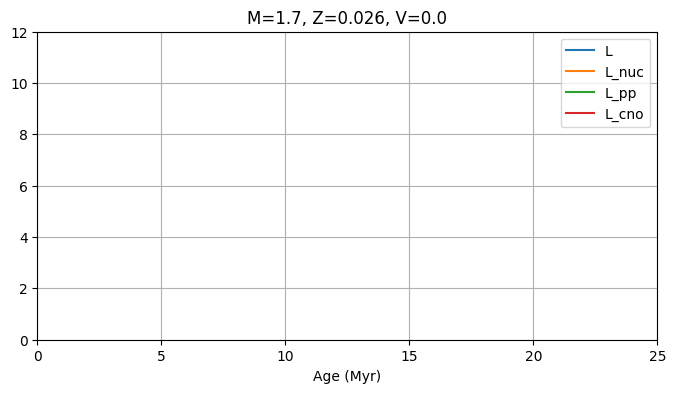

In [132]:
plt.figure(figsize=(8, 4))
plt.plot(dff["Myr"], 10**dff["logL"], label="L")
plt.plot(dff["Myr"], 10**dff["log_Lnuc"], label="L_nuc")
plt.plot(dff["Myr"], 10**dff["pp"], label="L_pp")
plt.plot(dff["Myr"], 10**dff["cno"], label="L_cno")
# plt.plot(dff["Myr"], dff["log_R"], label="log_R")
# plt.plot(dff["Myr"], dff["log_cntr_Rho"], label="log_cntr_Rho")
plt.grid()
plt.xlabel("Age (Myr)")
plt.xlim(0, 25)
plt.legend()
plt.ylim(0, 12)
plt.title(f"M={m}, Z={z}, V={v}")
plt.show()

In [6]:
hist = pd.read_csv(f"test_1.7_z/m{m}_z{z}_v0/LOGS/history.data", skiprows=5, delim_whitespace=True)
profile_index = pd.read_csv(f"test_1.7_z/m{m}_z{z}_v0/LOGS/profiles.index", skiprows=1, 
                            names=['model_number', 'priority', 'profile_number'], delim_whitespace=True)

profiles = []
ages = []
old = 0
for i, row in hist.iterrows():
    age = row.star_age/1e6
    new = int(age) + int(age * 10) % 10
    hist_model = row.model_number
    profile_model = profile_index.query(f"model_number=={row.model_number}").model_number.values
    if len(profile_model) !=0:
        profile_model = profile_model[0]
        if hist_model == profile_model:
            profile_number = profile_index.query(f"model_number=={row.model_number}").profile_number.values[0]
            if new > old:
                ages.append(new)
                profiles.append(pd.read_csv(f"test_1.7_z/m{m}_z{z}_v0/LOGS/profile{profile_number}.data", 
                                            skiprows=5, delim_whitespace=True))
                old = new

In [7]:
int(age) + int(age * 10) % 10

2062

In [8]:
profiles[0].columns

Index(['zone', 'mass', 'logR', 'logT', 'logRho', 'logP', 'x_mass_fraction_H',
       'y_mass_fraction_He', 'z_mass_fraction_metals', 'pp', 'cno',
       'tri_alpha', 'omega', 'brunt_N2', 'lamb_S'],
      dtype='object')

In [11]:
def plot_2d(args):
    plt.cla()
    age, profile = args
    palette = sns.color_palette("flare", len(profile))
    theta = np.linspace(0, 2*np.pi, 100)  # 100 points evenly spaced from 0 to 2*pi
    radius_max = 10**profile.logR.max()
    densities = 10**profile.logRho.sort_values()
    for i, row in profile.iterrows():
        radius = 10**row.logR
        # Convert 1D values to 2D Cartesian coordinates
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        di = np.where(densities == 10**row.logRho)[0][0]
        plt.plot(x, y, lw=1, color=palette[di])
    r = 5
    plt.xlim(-r, r)
    plt.ylim(-r, r)
    plt.title(f"Age: {age} Myr")


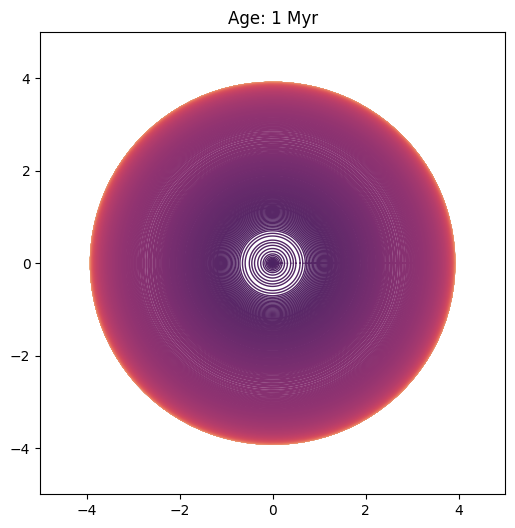

In [15]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

fig = plt.figure(figsize=(6, 6))
ani = FuncAnimation(fig, plot_2d, frames=zip(ages, profiles))

In [14]:
writer = animation.FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264', '-preset', 'slow', '-crf', '18'])
ani.save(f'figures/2d.mp4', writer=writer)

MovieWriter ffmpeg unavailable; using Pillow instead.


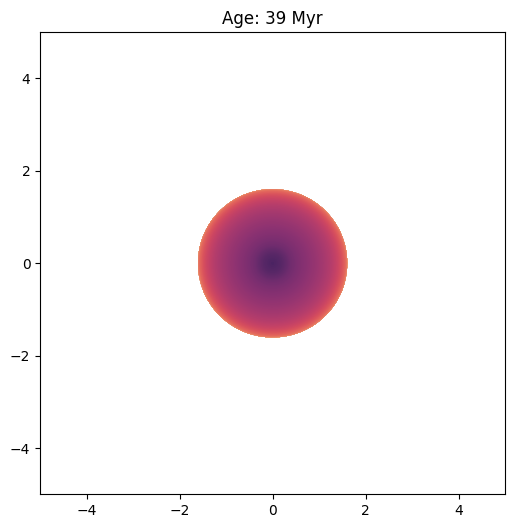

In [37]:
import time
from IPython import display

with plt.ion():
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    for i, profile in enumerate(profiles):
        try:
            palette = sns.color_palette("flare", len(profile))
            args = ages[i], profile
            plot_2d(args)
            # plt.colorbar(10**profile.logRho, label='Density')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            # time.sleep(0.1)
        except KeyboardInterrupt:
            break

In [15]:
1.349%10

1.349

In [243]:
ages_t = np.arange(0, 40, 0.1)

dfs = []
for tr_num in range(6):
    this_df = df[df.tr_num == tr_num]
    this_df = this_df.sort_values(by='Myr').reset_index()
    new_df = pd.DataFrame()
    new_df['Myr'] = ages_t
    for col in this_df.columns:
        if col not in ['Myr', 'tr_num', 'm', 'v', 'z']:
            f = interp1d(this_df["Myr"], this_df[col], kind='slinear', fill_value='extrapolate')
            new_df[col] = f(ages_t)
    dfs.append(new_df)


# dfs = []
# for tr_num in range(6):
#     this_df = df[df.tr_num == tr_num]
#     dfs.append(this_df.sort_values(by='Myr').reset_index())


In [198]:
x = dfs[0]-dfs[1]
x.n4ell1m0
dfs[1].Myr[40:50]

40    4.0
41    4.1
42    4.2
43    4.3
44    4.4
45    4.5
46    4.6
47    4.7
48    4.8
49    4.9
Name: Myr, dtype: float64

In [315]:
cols0 = ['n1ell0m0', 'n2ell0m0', 'n3ell0m0',
       'n4ell0m0', 'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0',
       'n10ell0m0']

cols1 = ['n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0',
         'n5ell1m0', 'n6ell1m0', 'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0']

ref = 0
df_ref = dfs[ref]
param_samples = np.round(np.append(np.arange(0.1, 1.4, 0.3), [1.25]), 3)
print("ref param: ", param_samples[ref])
mean_diffs = []
ages = []


for this_df in dfs:
    this_mean = []
    age = []
    for i, row in df_ref.iterrows():
        freqs_alt_0 = row[cols0]
        freqs_alt_1 = row[cols1]
        freqs_ref_0 = this_df.iloc[i][cols0]
        freqs_ref_1 = this_df.iloc[i][cols1]
        diff_0 = ((freqs_ref_0 - freqs_alt_0)/freqs_ref_0).fillna(0)
        diff_1 = ((freqs_ref_1 - freqs_alt_1)/freqs_ref_1).fillna(0)
        this_mean.append(np.mean( np.append(diff_0, diff_1) ))
        age.append(row["Myr"])
        if row["Myr"] > 40:
            break
    ages.append(age)
    mean_diffs.append(this_mean)

ref param:  0.1


In [290]:
diffs_save = np.array(mean_diffs)

In [328]:
# from scipy.signal import savgol_filter as filter
from scipy.signal import medfilt as filter
diffs = []
for i, mean_diff in enumerate(diffs_save):
    diffs.append(filter(mean_diff, 13))
mean_diffs = diffs

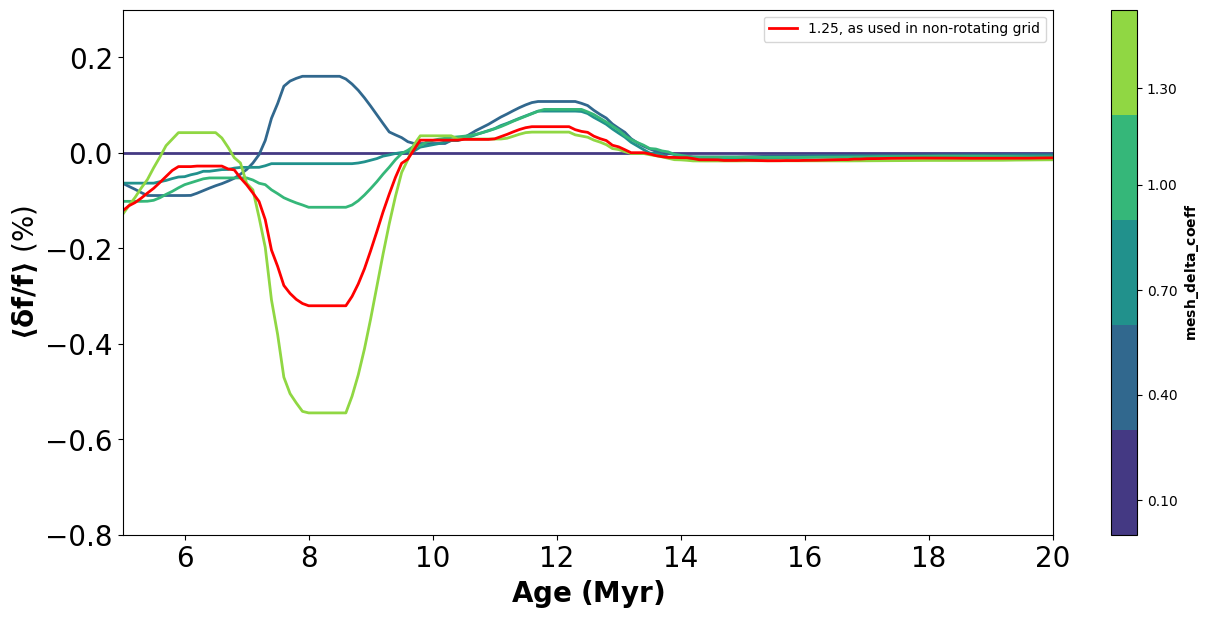

In [329]:
fig = plt.figure(figsize=(15, 15))
palette = sns.color_palette("viridis", len(param_samples))
# palette = sns.color_palette("colorblind", len(var_samples))
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]


ax1 = plt.subplot(2, 1, 1)
for ind, var in enumerate(param_samples):
    plt.plot(ages[ind], 100*np.array(mean_diffs[ind]), color=palette[ind], lw=2)
plt.plot(ages[-1], 100*np.array(mean_diffs[-1]), lw=2, color='red', label=f'1.25, as used in non-rotating grid')
plt.legend(loc='upper right')

title_font = mpl.font_manager.FontProperties(weight='black',
                                   style='normal', size=20)
font = mpl.font_manager.FontProperties(weight='bold',
                                   style='normal', size=18)
plt.xlim([5, 20])
plt.ylim([-0.8, 0.3])
plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle\ \rm{(\%)}$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)
# rect = mpl.patches.Rectangle((15, -0.001), 20, 0.004, linewidth=1, edgecolor='k', facecolor='grey', alpha=0.2)
# ax1.add_patch(rect)


# ax2 = plt.subplot(2, 1, 2)
# for ind, var in enumerate(var_samples):
#     # plt.plot(age, mean_diffs[ind], color=palette[ind], lw=2, linestyle=linestyle_tuple[ind][1])
#     plt.plot(ages[ind], mean_diffs[ind], color=palette[ind], lw=2)
# plt.plot(ages[-1], mean_diffs[-1], lw=2, color='red')
# plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
# plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle\ \rm{(\%)}$', size=20)
# plt.gca().xaxis.set_tick_params(labelsize=20)
# plt.gca().yaxis.set_tick_params(labelsize=20)
# plt.xlim([20, 500])
# plt.ylim([-0.01, 0.03])
# plt.subplots_adjust(wspace=0, hspace=0.3)


param_samples = np.arange(0.1, 1.4, 0.3)
Z = [[0,0],[0,0]]
levels = np.array(sorted(param_samples)+[1.7])
contour = plt.contourf(Z, levels, cmap=mpl.colors.ListedColormap(palette))
axes = [ax1]
cb = plt.colorbar(contour, ticks=levels+0.1, label=r'$\bf{mesh\_delta\_coeff}$', ax=axes)
cb.set_ticklabels([f"{level:.2f}" for level in levels])

# ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol=''))
# ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol=''))

fig.align_ylabels([ax1])
plt.show()
# plt.savefig(f'../figures/mean_diff_panels.pdf', dpi=300, bbox_inches='tight')